In [2]:
import numpy as np
import random
import keras
from keras import Sequential
from keras.models import Model
from keras.layers import Dense, Input, Convolution2D,MaxPooling2D,AveragePooling2D,Flatten,Dropout
from keras import optimizers
from keras.utils import np_utils
from skimage.draw import disk, rectangle,polygon #install scikit-image first
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.rcParams["figure.figsize"] = (3,3)

ModuleNotFoundError: No module named 'skimage'

In [2]:
np.random.seed(10)

### Generate Shapes

In [3]:
canvas_size=64
noisy=True
def create_disk(top_left, bottom_right,canvas_x=canvas_size,canvas_y=canvas_size):
    if noisy:
        canvas=np.random.rand(canvas_x, canvas_y)/2
    else:
        canvas=np.zeros((canvas_x, canvas_y), dtype=np.uint8)
    center=((bottom_right[0]+top_left[0])/2, (bottom_right[1]+top_left[1])/2)
    radius=(top_left[0]-bottom_right[0])/2
    canvas[tuple(disk(center, radius))] = 1
    return canvas

def create_rectangle(top_left, bottom_right,canvas_x=canvas_size,canvas_y=canvas_size):
    if noisy:
        canvas=np.random.rand(canvas_x, canvas_y)/2
    else:
        canvas=np.zeros((canvas_x, canvas_y), dtype=np.uint8)
    extent = (bottom_right[0]-top_left[0], bottom_right[1]-top_left[1])
    start  = top_left
    canvas[tuple(rectangle(start, extent=extent))] = 1
    return canvas

def create_triangle(top_left, bottom_right,canvas_x=canvas_size,canvas_y=canvas_size):
    if noisy:
        canvas=np.random.rand(canvas_x, canvas_y)/2
    else:
        canvas=np.zeros((canvas_x, canvas_y), dtype=np.uint8)
    x=[top_left[0],top_left[0],bottom_right[0]]
    y=[top_left[1],bottom_right[1],(top_left[1]+bottom_right[1])/2]
    canvas[tuple(polygon(x,y))] = 1
    return canvas

def create_random_shape(top_left, bottom_right,canvas_x=canvas_size,canvas_y=canvas_size):
    i = random.randint(1,3)
    if i==1:
        return create_disk(top_left, bottom_right,canvas_x,canvas_y)
    elif i==2:
        return create_rectangle(top_left, bottom_right,canvas_x,canvas_y)
    elif i==3:
        return create_triangle(top_left, bottom_right,canvas_x,canvas_y)

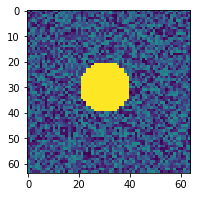

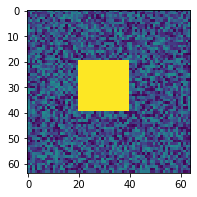

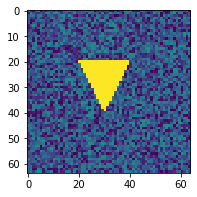

In [4]:
plt.imshow(create_disk((20,20),(40,40)))
plt.show()
plt.imshow(create_rectangle((20,20),(40,40)))
plt.show()
plt.imshow(create_triangle((20,20),(40,40)))
plt.show()

### Generate Training data

In [5]:
X_train,X_test,Y_train,Y_test=[],[],[],[]
for i in range(10000): #generate train set
    top_left=(random.randint(int(0.25*canvas_size),int(0.75*canvas_size)),random.randint(int(0.25*canvas_size),int(0.75*canvas_size)))
    side_length=random.randint(int(0.1*canvas_size),int(0.2*canvas_size))
    bottom_right=(top_left[0]+side_length,top_left[1]+side_length)
    X_train+=[create_random_shape(top_left, bottom_right)]
    Y_train+=[top_left+bottom_right]
for i in range(200): #generate test set
    top_left=(random.randint(int(0.25*canvas_size),int(0.75*canvas_size)),random.randint(int(0.25*canvas_size),int(0.75*canvas_size)))
    side_length=random.randint(int(0.1*canvas_size),int(0.2*canvas_size))
    bottom_right=(top_left[0]+side_length,top_left[1]+side_length)
    X_test+=[create_random_shape(top_left, bottom_right)]
    Y_test+=[top_left+bottom_right]
X_train=np.array(X_train)
Y_train=np.array(Y_train)

X_test=np.array(X_test)
Y_test=np.array(Y_test)

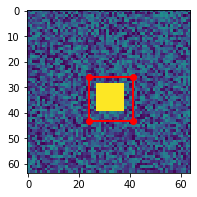

In [6]:
def plot(X,Y):
    plt.imshow(X)
    padding=int(0.05*canvas_size)
    plt.scatter([Y[1]-padding,Y[3]+padding,Y[1]-padding,Y[3]+padding],\
                [Y[0]-padding,Y[2]+padding,Y[2]+padding,Y[0]-padding],c='red')
    ax = plt.gca()
    ax.add_patch(patches.Rectangle((Y[1]-padding,Y[0]-padding),Y[3]-Y[1]+2*padding,\
                                   Y[2]-Y[0]+2*padding,linewidth=2,edgecolor='r',facecolor='none'))
    return plt
plot(X_train[0],Y_train[0]).show()

### Convert data

In [7]:
X_train = X_train.reshape(X_train.shape[0], canvas_size, canvas_size,1)
X_test = X_test.reshape(X_test.shape[0], canvas_size, canvas_size,1)

#Normalization
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
Y_train = Y_train.astype('float32')/canvas_size
Y_test = Y_test.astype('float32')/canvas_size

### Build Model

In [8]:
model = Sequential()
model.add(MaxPooling2D(pool_size=(4,4),input_shape=(canvas_size,canvas_size,1)))
model.add(Convolution2D(10, (3,3)))
model.add(Convolution2D(16, (3,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D(8, (3,3)))
model.add(Convolution2D(8, (3,3)))
model.add(Flatten())
model.add(Dense(4))
model.build()

### Train

In [9]:
model.compile(optimizer='adam',loss='mse')

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 10)        100       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 16)        1456      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 8)           1160      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 8)           584       
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)               

In [11]:
history=model.fit(X_train, Y_train, epochs=40,validation_split=0.1, shuffle=True, verbose=1)

Train on 9000 samples, validate on 1000 samples
Epoch 1/40
9000/9000 [==============================] - 4s 406us/step - loss: 0.0196 - val_loss: 0.0053
Epoch 2/40
9000/9000 [==============================] - 3s 361us/step - loss: 0.0034 - val_loss: 0.0025
Epoch 3/40
9000/9000 [==============================] - 3s 368us/step - loss: 0.0021 - val_loss: 0.0019
Epoch 4/40
9000/9000 [==============================] - 3s 364us/step - loss: 0.0015 - val_loss: 0.0016
Epoch 5/40
9000/9000 [==============================] - 3s 374us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 6/40
9000/9000 [==============================] - 4s 392us/step - loss: 0.0010 - val_loss: 0.0011
Epoch 7/40
9000/9000 [==============================] - 4s 431us/step - loss: 9.3840e-04 - val_loss: 9.2815e-04
Epoch 8/40
9000/9000 [==============================] - 5s 512us/step - loss: 8.5567e-04 - val_loss: 8.9809e-04
Epoch 9/40
9000/9000 [==============================] - 6s 613us/step - loss: 7.8164e-04 - val_loss: 7.4

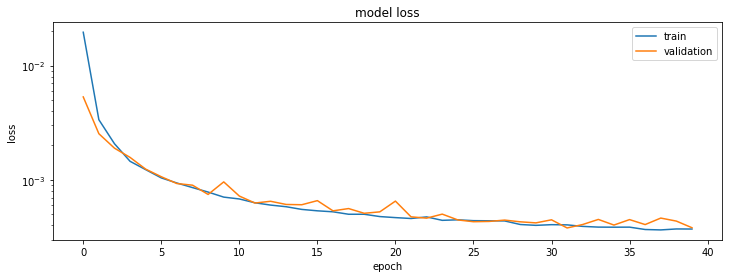

In [12]:
plt.figure(figsize=(12,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Evaluate

In [13]:
score = model.evaluate(X_test, Y_test, verbose=1)
print("loss: ", score)

200/200 [==============================] - 0s 276us/step
loss:  0.00034668880747631194


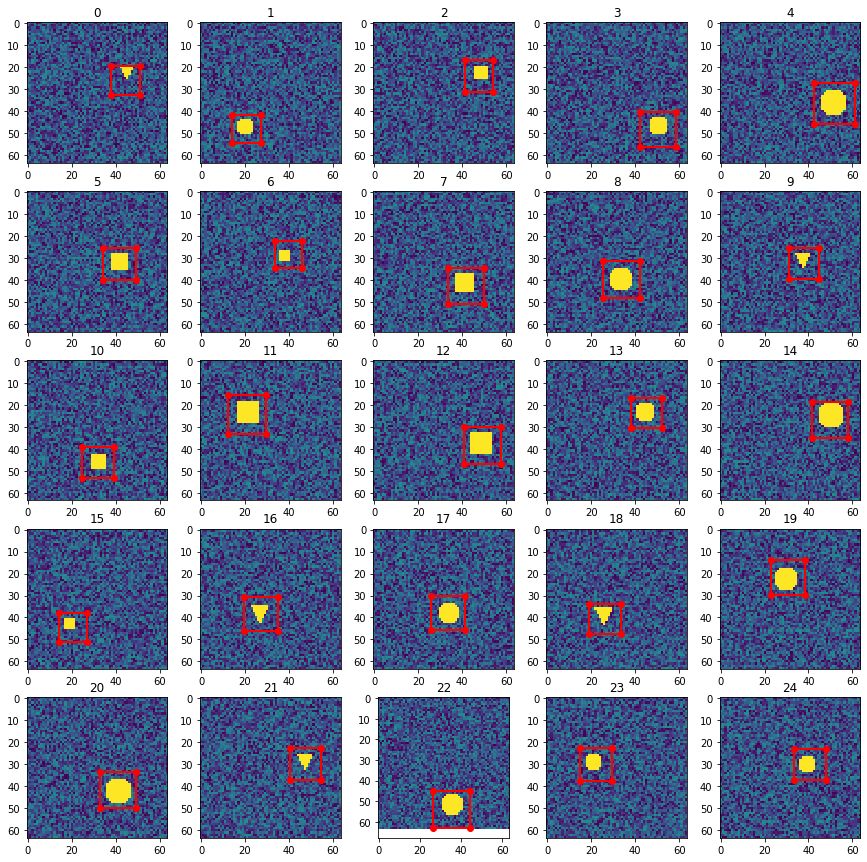

In [14]:
plt.figure(figsize=(15,15))
for i in range(25):
    ax= plt.subplot(5,5,i+1)
    k = random.randint(0,len(X_test))-1
    x=X_test[k].flatten().reshape(canvas_size,canvas_size)
    y=model.predict(np.array([X_test[k]]))[0]*canvas_size
    im=plot(x,y)
    plt.title(i)